# Softmax regression

In this exercise you will train a softmax regression model to recognize handwritten digits.
  
The general setup is as follows:
* we are given a set of pairs $(x, y)$, where $x \in R^D$ is a vector of real numbers representing the features, and $y \in \{1,...,c\}$ is the target (in our case we have ten classes, so $c=10$),
* for a given $x$ we model the probability of $y=j$ by $$h(x)_j=p_j = \frac{e^{w_j^Tx}}{\sum_{i=1}^c e^{w_i^Tx}},$$
* to find the right $w$ we will optimize the so called multiclass log loss:
$$L(y,p) = \log{p_y},$$
$$J(w) = -\frac{1}{n}\sum_{i=1}^n L(y_i,h(x)),$$
* with the loss function in hand we can improve our guesses iteratively:
    * $w_{ij}^{t+1} = w_{ij}^t - \text{step_size} \cdot \frac{\partial J(w)}{\partial w_{ij}}$,
* we can end the process after some predefined number of epochs (or when the changes are no longer meaningful).

Let's start with importing the MNIST dataset.

In [1]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2021-04-02 20:16:54--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.67.6
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.67.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  35.9MB/s    in 0.3s    

2021-04-02 20:16:54 (35.9 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

Let's take a look at the data. In the "x" arrays you'll find the images (encoded as pixel intensities) and in the "y" ones you'll find the labels (one-hot encoded).

In [3]:
print(x_train.shape)
print(y_train.shape)

print(x_train[:10])
print(y_train[:10])

(60000, 784)
(60000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Now let us see the data in a more human way.

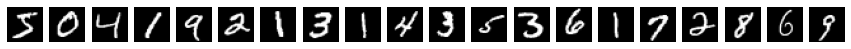

In [4]:
num_samples = 20
samples = range(num_samples)
fig, subplots = plt.subplots(1, num_samples)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(x_train[i, :], [28, 28]), cmap='gray')
    s.axis('off')

Next, we prepare $X$ and $y$ variables

In [5]:
X = x_train[:4000]
y = y_train[:4000]

print(X.shape)
print(y.shape)

(4000, 784)
(4000, 10)


To train the model we will (obviously) use gradient descent. Inside the loop we need a method to compute the gradients. Let's start with implementing it, together with some helper functions.

In [12]:
# We will store the weights in a D x c matrix, where D is the number of features, and c is the number of classes
#weights = (...) # TODO: Fill in, be sure to have the right shape!
weights = np.zeros([X.shape[1], 10])


def softmax(z):
    ########################################
    # TODO: implement the softmax function #
    ########################################
    np.exp(z) / np.exp(z).sum(axis=0)
    return 0.

def predict(weights, X):
    ###################################
    # TODO: compute the probabilities #
    ###################################
    r1 = np.dot(X, weights)
    r1 = r1 - np.max(r1, axis=1, keepdims=True)
    r1 = np.exp(r1)
    r1 = r1 / np.sum(r1, axis=1, keepdims=True)
    return r1

def compute_loss_and_gradients(weights, X, y, l2_reg):
    #############################################################################
    # TODO: compute loss and gradients, don't forget to include regularization! #
    #############################################################################
    s = predict(weights, X)
    loss = -np.sum(np.log(np.sum(s * y, axis=1))) / X.shape[0]
    grad = np.dot(X.T, s - y) / X.shape[0]

    return loss, grad

We are now in position to complete the training pipeline.

If you have problems with convergence, be sure to check the gradients numerically.

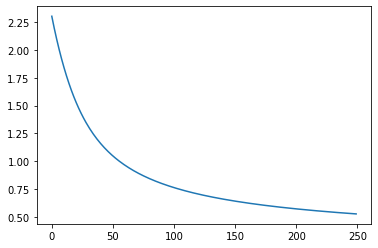

In [13]:
l2_reg = 0.5
n_epochs = 250
lr = 0.05

losses = []
for i in range(n_epochs):
    loss, grad = compute_loss_and_gradients(weights, X, y, l2_reg)
    losses.append(loss)
    
    weights -= lr * grad

plt.plot(losses)

Now compute your accuracy on the training and test sets.

In [14]:
##############################
# TODO: compute the accuracy #
##############################
def accuracy(x, y):
  p = np.argmax(predict(weights, X), axis=1)
  correct = sum(y[i][p] for i, p in enumerate(p))
  return correct/y.shape[0]

print('accuracy on train: ', accuracy(x_train, y_train))
print('accuracy on test: ', accuracy(x_test, y_test))


accuracy on train:  0.0586
accuracy on test:  0.0386


We can also visualize the weights learned by our algorithm. Try to anticipate the result before executing the cell below.

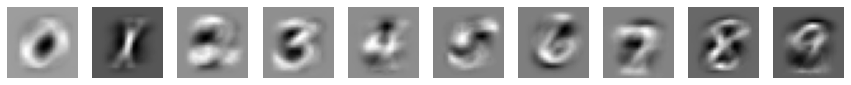

In [15]:
fig, subplots = plt.subplots(1, 10)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(np.array(weights[:, i]), [28, 28]), cmap='gray')
    s.axis('off')

Note that we only used a small portion of the data to develop the model. Now, implement the training on full data. Also, validate your model properly and find a good value for `l2_reg` hyperparameter. Try to experiment with `batch_size`.

In [24]:
################################################
# TODO: implement the proper training pipeline #
################################################
permuted_indexes = np.random.permutation(range(x_train.shape[0]))

X = x_train[permuted_indexes[:50000]]
y = y_train[permuted_indexes[:50000]]
x_val = x_train[permuted_indexes[50000:]]
y_val = y_train[permuted_indexes[50000:]]


In [27]:
def SGD(X, y, x_val, y_val, n_epochs = 25, batch_size = 100, l2_reg = 1., lr = 0.05):
  weights = np.zeros([X.shape[1], 10])

  losses = []
  losses_val = []
  
  n_batches = int(X.shape[0]/batch_size)  
  for i in range(n_epochs):
    for j in range(n_batches):
      idx = np.arange(j*batch_size, (j+1)*batch_size)   
      
      loss, grad = compute_loss_and_gradients(weights, X[idx,:], y[idx], l2_reg)
      losses.append(loss)
      loss,_ = compute_loss_and_gradients(weights, x_val, y_val, l2_reg)
      losses_val.append(loss)
    
      weights -= lr * grad
  return weights, losses, losses_val

Test accuracy: 0.9217


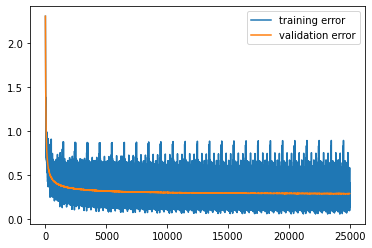

In [28]:
weights, losses, losses_val = SGD(X, y, x_val, y_val, n_epochs = 25,
                                  batch_size = 50, l2_reg = 0.)

plt.plot(losses, label = 'training error')
plt.plot(losses_val, label = 'validation error')
plt.legend()

preds = predict(weights, x_test)
preds_test_set = np.argmax(preds, axis = 1)
accuracy_test_set = np.mean(preds_test_set == np.nonzero(y_test)[1])
print("Test accuracy: {:}".format(accuracy_test_set))